In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs

2023-06-12 10:49:10.178094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 10:49:30.406380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
df = pd.read_csv('230106_frozen_metadata.csv.gz')

/var/folders/_5/04k_n4g93v9bhbfk8nqpr3zr0000gs/T/ipykernel_3142/2942701605.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('230106_frozen_metadata.csv.gz')


In [3]:
#Remove duplicate organism-molecule pair
df_agg = df.groupby(['organism_taxonomy_09species',
                     'structure_smiles_2D']).size().reset_index(name='reference_wikidata')

df_agg = df.groupby(['organism_taxonomy_09species', 'structure_smiles_2D']).agg({
    'reference_wikidata': 'size',
    'organism_taxonomy_08genus': 'first',
    'organism_taxonomy_06family': 'first',
    'organism_taxonomy_05order': 'first',
    'organism_taxonomy_04class': 'first',
    'organism_taxonomy_03phylum': 'first',
    'organism_taxonomy_02kingdom': 'first',
    'organism_taxonomy_01domain': 'first',
    'structure_taxonomy_npclassifier_01pathway': 'first',
    'structure_taxonomy_npclassifier_02superclass': 'first',
    'structure_taxonomy_npclassifier_03class': 'first'
    # add other columns here as needed
}).reset_index()

df_agg['total_papers_molecule'] = df_agg.groupby(
    'structure_smiles_2D')['reference_wikidata'].transform('sum')
df_agg['total_papers_species'] = df_agg.groupby(
    'organism_taxonomy_09species')['reference_wikidata'].transform('sum')

#get the first 30'000 entries (remove for full dataset)
df_agg = df_agg.sample(n=10000).reset_index(drop=True)

In [4]:
# Fetch unique species and molecules and their respective features
unique_species_df = df_agg.drop_duplicates(subset=['organism_taxonomy_09species'])
unique_molecules_df = df_agg.drop_duplicates(subset=['structure_smiles_2D'])

# Fetch the corresponding features
species_features_df = unique_species_df[['organism_taxonomy_08genus', 'organism_taxonomy_06family', 
                                         'organism_taxonomy_05order', 'organism_taxonomy_04class', 
                                         'organism_taxonomy_03phylum', 'organism_taxonomy_02kingdom', 
                                         'organism_taxonomy_01domain']]
molecule_features_df = unique_molecules_df[['structure_taxonomy_npclassifier_01pathway', 
                                            'structure_taxonomy_npclassifier_02superclass', 
                                            'structure_taxonomy_npclassifier_03class']]

# Convert these dataframes to dummy/one-hot encoded dataframes
species_features_dummy = pd.get_dummies(species_features_df)
molecule_features_dummy = pd.get_dummies(molecule_features_df)
species_features_dummy.index = [i for i in unique_species_df['organism_taxonomy_09species']]
molecule_features_dummy.index = [i for i in unique_molecules_df['structure_smiles_2D']]

In [47]:
g = nx.Graph()
for i, row in df_agg.iterrows():
    g.add_edge(row['structure_smiles_2D'],
               row['organism_taxonomy_09species'])
    nx.set_node_attributes(g,
                           {row['structure_smiles_2D']: 'molecule',
                            row['organism_taxonomy_09species']: 'species'}, "label")
    nx.set_edge_attributes(g,
                          {(row['structure_smiles_2D'],
                            row['organism_taxonomy_09species']):
                           {'weight':row['reference_wikidata']}})

In [48]:
fps = [AllChem.MolFromSmiles(i) for i in unique_molecules_df['structure_smiles_2D']]
mols  = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024) for m in fps]

# Iterate over each pair of molecules
for i, j in itertools.combinations(range(len(fps)), 2):
    # Calculate the Tanimoto Similarity
    similarity = DataStructs.TanimotoSimilarity(mols[i], mols[j])
    # If the similarity is above 0.9, add an edge
    if similarity >= 0.8:
        g.add_edge(unique_molecules_df['structure_smiles_2D'].values[i], 
                  unique_molecules_df['structure_smiles_2D'].values[j])
        nx.set_edge_attributes(g,
                              {(unique_molecules_df['structure_smiles_2D'].values[i],
                              unique_molecules_df['structure_smiles_2D'].values[j]):{'weight': similarity}})

In [7]:
#mols_as_binary = [np.array(i) for i in mols]
#df_binary_mols = pd.DataFrame(mols_as_binary)
#df_binary_mols.index = [i for i in unique_molecules_df['structure_smiles_2D']]

In [49]:
g = g.to_directed()

In [50]:
nx.write_graphml(g, "./lotus_DB_as_graph.gml")

In [51]:
g = nx.read_graphml("./lotus_DB_as_graph.gml")

In [52]:
G = StellarGraph.from_networkx(
    g, node_features={'species':species_features_dummy,
                      'molecule': molecule_features_dummy}
)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 13735, Edges: 23578

 Node types:
  molecule: [7109]
    Features: float32 vector, length 567
    Edge types: molecule-default->molecule, molecule-default->species
  species: [6626]
    Features: float32 vector, length 3880
    Edge types: species-default->molecule

 Edge types:
    species-default->molecule: [10000]
        Weights: range=[1, 180], mean=1.876, std=2.78011
        Features: none
    molecule-default->species: [10000]
        Weights: range=[1, 180], mean=1.876, std=2.78011
        Features: none
    molecule-default->molecule: [3578]
        Weights: range=[0.8, 1], mean=0.910871, std=0.0787247
        Features: none


In [10]:
G.check_graph_for_ml()

In [11]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
batch_size = 32
epochs = 20
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2

In [13]:
edges_with_ratings = df_agg[['structure_smiles_2D',
                             'organism_taxonomy_09species',
                            'reference_wikidata']]
#edges_with_ratings['prob_presence'] = 1-np.exp(-0.005*edges_with_ratings['total_papers_molecule']\
#                                               -0.05*edges_with_ratings['total_papers_species'])

In [14]:
edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["structure_smiles_2D", "organism_taxonomy_09species"]].itertuples(index=False))
edgelist_test = list(edges_test[["structure_smiles_2D", "organism_taxonomy_09species"]].itertuples(index=False))

labels_train = edges_train["reference_wikidata"]
labels_test = edges_test["reference_wikidata"]

In [15]:
num_samples = [8, 4]
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["molecule", "species"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)


In [16]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('molecule', [2, 3]),
 ('species', [4]),
 ('molecule', [5, 6]),
 ('species', [7]),
 ('molecule', [8, 9]),
 ('molecule', []),
 ('species', []),
 ('molecule', []),
 ('molecule', []),
 ('species', [])]

In [17]:
generator.schema.schema

{'molecule': [EdgeType(n1='molecule', rel='default', n2='molecule'),
  EdgeType(n1='molecule', rel='default', n2='species')],
 'species': [EdgeType(n1='species', rel='default', n2='molecule')]}

In [18]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [19]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [20]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [21]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 567)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 3880)]    0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32, 567)]    0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 32, 3880)]   0           []                               
                                                                                              

                                                                                                  
 reshape_10 (Reshape)           (None, 1, 8, 16)     0           ['mean_hin_aggregator[2][0]']    
                                                                                                  
 dropout_15 (Dropout)           (None, 1, 16)        0           ['mean_hin_aggregator[0][0]']    
                                                                                                  
 dropout_13 (Dropout)           (None, 1, 8, 16)     0           ['reshape_8[0][0]']              
                                                                                                  
 dropout_14 (Dropout)           (None, 1, 8, 16)     0           ['reshape_9[0][0]']              
                                                                                                  
 dropout_17 (Dropout)           (None, 1, 16)        0           ['mean_hin_aggregator_1[0][0]']  
          

In [23]:
# Specify the number of workers to use for model training
num_workers = 2

In [24]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

10/10 [==============================] - 4s 294ms/step - loss: 8.1118 - root_mean_square_error: 2.8285 - mean_absolute_error: 2.0812
Untrained model's Test Evaluation:
	loss: 8.1118
	root_mean_square_error: 2.8285
	mean_absolute_error: 2.0812


In [25]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
40/40 [==============================] - 21s 445ms/step - loss: 8.8700 - root_mean_square_error: 2.3029 - mean_absolute_error: 1.0737 - val_loss: 3.6070 - val_root_mean_square_error: 1.8582 - val_mean_absolute_error: 1.0480
Epoch 2/20
40/40 [==============================] - 18s 442ms/step - loss: 8.3865 - root_mean_square_error: 2.2249 - mean_absolute_error: 0.9766 - val_loss: 3.4662 - val_root_mean_square_error: 1.8153 - val_mean_absolute_error: 0.9897
Epoch 3/20
40/40 [==============================] - 18s 443ms/step - loss: 8.0012 - root_mean_square_error: 2.1327 - mean_absolute_error: 0.9077 - val_loss: 3.5626 - val_root_mean_square_error: 1.8429 - val_mean_absolute_error: 0.9094
Epoch 4/20
40/40 [==============================] - 18s 442ms/step - loss: 7.7579 - root_mean_square_error: 2.0976 - mean_absolute_error: 0.8630 - val_loss: 3.5267 - val_root_mean_square_error: 1.8343 - val_mean_absolute_error: 1.0562
Epoch 5/20
40/40 [==============================] - 19s 450m

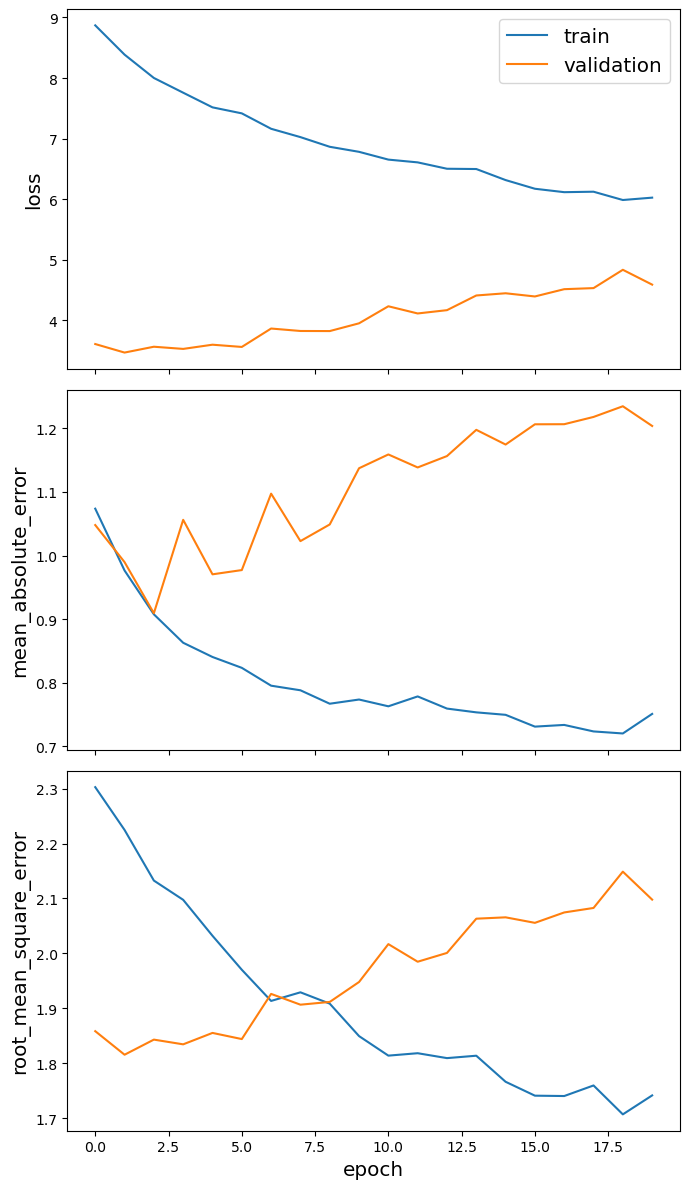

In [26]:
sg.utils.plot_history(history)

In [27]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


10/10 [==============================] - 3s 269ms/step - loss: 4.6167 - root_mean_square_error: 2.1038 - mean_absolute_error: 1.2080
Test Evaluation:
	loss: 4.6167
	root_mean_square_error: 2.1038
	mean_absolute_error: 1.2080


In [28]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

10/10 [==============================] - 5s 423ms/step
Mean Baseline Test set metrics:
	root_mean_square_error =  1.9227893800414024
	mean_absolute_error =  1.011042994260788

Model Test set metrics:
	root_mean_square_error =  2.150829280818316
	mean_absolute_error =  1.211742818325758


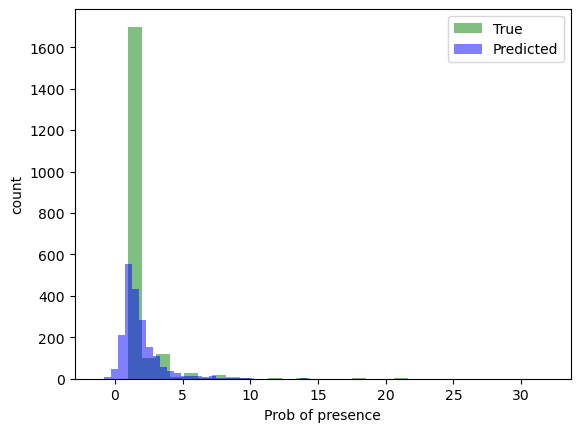

In [29]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("Prob of presence")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [30]:
test_gen_2 = generator.flow(edgelist_test, np.zeros(len(labels_test)))

In [31]:
mv = model.predict(test_gen_2)

10/10 [==============================] - 5s 420ms/step


In [32]:
np.corrcoef(mv.flatten(), y_true.to_numpy())

array([[1.        , 0.23901172],
       [0.23901172, 1.        ]])

In [33]:
pd.DataFrame(edgelist_test)

,structure_smiles_2D,organism_taxonomy_09species
0,CC=C(C)C(=O)OC1CCC2(C)C3CCC4C5(O)C(O)C(O)C6C(C...,Veratrum oblongum
1,CCCCCCCCCCCCCCCCCCC,Vitis vinifera
2,CCC12CCCN3CCC4c5ccccc5N(C)C4(CC1)C32,Vallesia glabra
3,COC(=O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C2C1CC(O)C2CO,Galium rhodopeum
4,C=CC1(C)C=C2CCC3C(C)(C(=O)O)CCCC3(C)C2CC1,Ferula marmarica
...,...,...
1995,CC1C2(O)CC34CC(=O)OC3(CC(O)C4C)C1(C)CO2,Illicium merrillianum
1996,CC(=O)OC1CC(C)C23OC(C)(C)C(CC(OC(=O)c4ccccc4)C...,Tripterygium wilfordii
1997,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1O,Haplopappus canescens
1998,C=CC(=C)CCC=C(C)C,Cephalotaxus mannii


In [42]:
x = list(pd.DataFrame({'structure_smiles_2D': ['Oc1ccc2c(c1)OC(c1cc(O)c(O)c(O)c1)C(O)C2'],
             'organism_taxonomy_09species': ['Commiphora rostrata']}).itertuples(index=False))

In [43]:
model.predict(generator.flow(x, np.array([0])))

1/1 [==============================] - 0s 39ms/step


array([[0.4393021]], dtype=float32)